In [ ]:
# system imports
import os
import sys

# data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

# signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz


# misc
import warnings



##
import pytz
import datetime as dt
import math
import seaborn as sns


In [ ]:
# style settings
sns.set(style='whitegrid', rc={'axes.facecolor': '#EFF2F7'})

## psychopy  and shimmer related 

In [ ]:
def read_manipulate_psychopy(psychopy_path):
    
    psychopy_df = pd.read_csv(psychopy_path)
    col_list = [col for col in psychopy_df.columns if col.endswith('_ts')]
    col_list.insert(0, "Reference_time")
    psychopy_df_selected = psychopy_df[col_list]
    
    return psychopy_df_selected


def get_nonNan_list_psychopy(psychopy_df, col_name):
    
    
    selected_vals=[val for val in psychopy_df[col_name].to_list() if not(math.isnan(val))]
    
    return selected_vals



#######---------------------------------------------------
###### ------------------Shimmer--------------------------
###----------------------------------------------------------


def read_shimmer_sensor(sensor_file_path):
    
    shimmer_df = pd.read_csv(sensor_file_path, sep='\t', low_memory=False)
    shimmer_df = shimmer_df.reset_index()
    shimmer_df.columns = shimmer_df.iloc[0]
    shimmer_df.drop([0, 1], axis=0, inplace=True)
    shimmer_df=shimmer_df.reset_index(drop=True)
    
    return shimmer_df

def standardize_timestamps_shimmer(shimmer_df, timestamps_col_name):
    
    timesstamps_list = shimmer_df[timestamps_col_name].to_list()
    new_timestamps_list = [float(val)/1000 for val in  timesstamps_list]
    
    shimmer_df[timestamps_col_name] = new_timestamps_list
    
    return shimmer_df



def get_offset_timestamp(timestamp, offset_mins):
    
    time_zone = 'Europe/Berlin'
    tz = pytz.timezone(time_zone)
    local_time = dt.datetime.fromtimestamp(timestamp, tz)
    time_change = dt.timedelta(minutes=offset_mins)
    new_time = local_time + time_change
    new_timestamp =  dt.datetime.timestamp(new_time)
    return new_timestamp

def get_list_timestamp_interest(starting_timestamp, list_offset_mins):
    
    starting_timestamp_list=[]
    
    for offset_min in list_offset_mins:
        starting_timestamp_list.append(starting_timestamp)
        timestamp_offset = get_offset_timestamp(starting_timestamp, offset_min)
        starting_timestamp = timestamp_offset  
     
    
    #starting_timestamp_list = sorted(starting_timestamp_list, key = lambda x:float(x))
    return starting_timestamp_list
        
        

def slice_df_wrt_timestamps(df, start_timestamp, end_timestamp, timestamps_col):
    
    sliced_df=df[(df[timestamps_col]>= start_timestamp) & (df[timestamps_col] <= end_timestamp)]
    
    return sliced_df


def from_str_to_float(str_list):
    
    float_array =[float(val) for val in str_list]
    
    return float_array

def col_from_str_float (df, col_name):
    
    str_list = df[col_name].values
    
    float_array =[float(val) for val in str_list]
    
    df[col_name] = float_array
    
    return df
    

## HRV related functions--------------------

In [14]:
def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter, which is just a part of the sine function
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity



def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = label(np.diff(p) < threshold)

    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output

def group_peaks_from_ind_to_msec(grouped_peaks_ind, sampling_freq):
    
    
    #grouped_peak_ascending = sorted(grouped_peaks_ind, key = lambda x:float(x))
    
    #grouped_peak_ascending_np=np.array(grouped_peak_ascending)
    grouped_peak_sec = grouped_peaks_ind*(1/sampling_freq)
    
    grouped_peak_msec = grouped_peak_sec*1000
    
    return grouped_peak_msec
    


def timedomain(rr):
    results = {}

    hr = 60000/rr
    
    results['Mean RR (ms)'] = np.mean(rr)
    results['STD RR/SDNN (ms)'] = np.std(rr)
    #results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(rr)
    #results['Mean HR (beats/min)'] = np.mean(hr)
    #results['STD HR (beats/min)'] = np.std(hr)
    #results['Min HR (beats/min)'] = np.min(hr)
    #results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
    results['NNxx'] = np.sum(np.abs(np.diff(rr)) > 100)*1
    results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > 100)*1) / len(rr)
    return results



def filter_rr(rr, throshold_high=0.5, threshold_low=0.5):
    
    #outlier_high = np.mean(rr) + throshold_high * np.std(rr)
    outlier_high =1400
    print(outlier_high)
    
    rr_clean_high = [rr_val for rr_val in rr if rr_val <  outlier_high]
    
    rr_clean_high = np.array(rr_clean_high)
    
    #outlier_low = np.mean(rr_clean_high) - threshold_low*np.std(rr_clean_high)
    outlier_low = 600
    print(outlier_low)
    
    rr_clean_high_low = [rr_val for rr_val in rr_clean_high if rr_val >  outlier_low]
    
    rr_clean_high_low= np.array(rr_clean_high_low)
    
    return rr_clean_high_low
        
        
    


def get_plot_ranges(start=10, end=20, n=5):
    '''
    Make an iterator that divides into n or n+1 ranges. 
    - if end-start is divisible by steps, return n ranges
    - if end-start is not divisible by steps, return n+1 ranges, where the last range is smaller and ends at n
    
    # Example:
    >> list(get_plot_ranges())
    >> [(0.0, 3.0), (3.0, 6.0), (6.0, 9.0)]

    '''
    distance = end - start
    for i in np.arange(start, end, np.floor(distance/n)):
        yield (int(i), int(np.minimum(end, np.floor(distance/n) + i)))

## paths  and inputs

In [64]:
event_interest_list_new = ["baseline_instruction_ts", "tsst_prep_ts", "tsst_pres_ts", "relaxation_prep_ts", "saliva_probe_4_ts", "saliva_probe_4_ts"]

In [87]:
psychopy_file_path = "/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP005_081123/Psychopy_data/VP005_081123_DigiRelax_Experiment_2023-11-08_14h17.35.226.csv"
col_interest_psychopy = event_interest_list_new[4]
list_offset_mins = [5]
selec_ind = 0
sampling_frequency = 256
ecg_file_path = "/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP005_081123/Shimmer_data/2023-11-08_13.52.04_VP005_081123_SD_Session1/VP005_081123_Session1_Shimmer_6B1E_Calibrated_SD.csv"
ecg_col_name = "Shimmer_6B1E_ECG_LL-LA_24BIT_CAL"
timestamp_shimmer_col_name = "Shimmer_6B1E_Timestamp_Unix_CAL"

In [88]:

####-------------------extracting psychopy inofomration--------------------------
psychopy_df = read_manipulate_psychopy(psychopy_file_path)
timestamp_ineterest = get_nonNan_list_psychopy(psychopy_df, col_interest_psychopy)[0]

######------------- extracting heart rate information----------------------------------
ecg_df = read_shimmer_sensor(ecg_file_path)
selected_ecg_df = ecg_df[[timestamp_shimmer_col_name, ecg_col_name]]
selected_ecg_df = selected_ecg_df.copy()
selected_ecg_df = standardize_timestamps_shimmer(selected_ecg_df, timestamp_shimmer_col_name)
selected_ecg_df['heartrate'] = selected_ecg_df[ecg_col_name]
selected_ecg_df=col_from_str_float (selected_ecg_df, "heartrate")
timestamps_interest_list = get_list_timestamp_interest(timestamp_ineterest, list_offset_mins)

timestamp_ineterest = timestamps_interest_list[selec_ind]
offset_min = list_offset_mins[selec_ind]
timestamp_offset = get_offset_timestamp(timestamp_ineterest, offset_min)
start_end_time_list = [timestamp_ineterest, timestamp_offset]
timestamp_start_slice = min(start_end_time_list)
timestamp_end_slice = max(start_end_time_list)

ecg_df_ii=slice_df_wrt_timestamps(selected_ecg_df, timestamp_start_slice, timestamp_end_slice, timestamp_shimmer_col_name)
ecg_df_ii=ecg_df_ii.reset_index(drop=True)



cond_slice_main = (ecg_df_ii[timestamp_shimmer_col_name] >= timestamp_start_slice) & (ecg_df_ii[timestamp_shimmer_col_name] < timestamp_end_slice)
ecg_slice = ecg_df_ii.heartrate[cond_slice_main] 
# detect peaks
peaks, similarity = detect_peaks(ecg_slice, threshold=0.3)
grouped_peaks = group_peaks(peaks)
grouped_peak_msec =group_peaks_from_ind_to_msec(grouped_peaks, 256)
rr = np.diff(grouped_peak_msec)
print(timedomain(rr))
cleaned_rr = filter_rr(rr)






{'Mean RR (ms)': 866.3996848739496, 'STD RR/SDNN (ms)': 80.31468829008242, 'RMSSD (ms)': 47.10993111882594, 'NNxx': 3, 'pNNxx (%)': 2.5210084033613445}
1400
600


In [89]:
cleaned_rr

array([ 890.625   ,  845.703125,  751.953125,  742.1875  ,  779.296875,
        873.046875,  947.265625,  925.78125 ,  925.78125 ,  933.59375 ,
        949.21875 ,  894.53125 ,  894.53125 ,  957.03125 ,  949.21875 ,
        939.453125,  949.21875 ,  853.515625,  830.078125,  873.046875,
        933.59375 ,  982.421875, 1003.90625 ,  992.1875  ,  964.84375 ,
        945.3125  ,  931.640625,  962.890625, 1003.90625 ,  974.609375,
        935.546875,  908.203125,  957.03125 ,  988.28125 , 1003.90625 ,
        970.703125,  958.984375,  988.28125 ,  974.609375,  970.703125,
        871.09375 ,  878.90625 ,  933.59375 ,  976.5625  ,  960.9375  ,
        912.109375,  869.140625,  816.40625 ,  839.84375 ,  847.65625 ,
        828.125   ,  777.34375 ,  841.796875,  873.046875,  859.375   ,
        843.75    ,  785.15625 ,  820.3125  ,  878.90625 ,  894.53125 ,
        910.15625 ,  855.46875 ,  800.78125 ,  824.21875 ,  847.65625 ,
        781.25    ,  755.859375,  824.21875 ,  882.8125  ,  867.

300.0


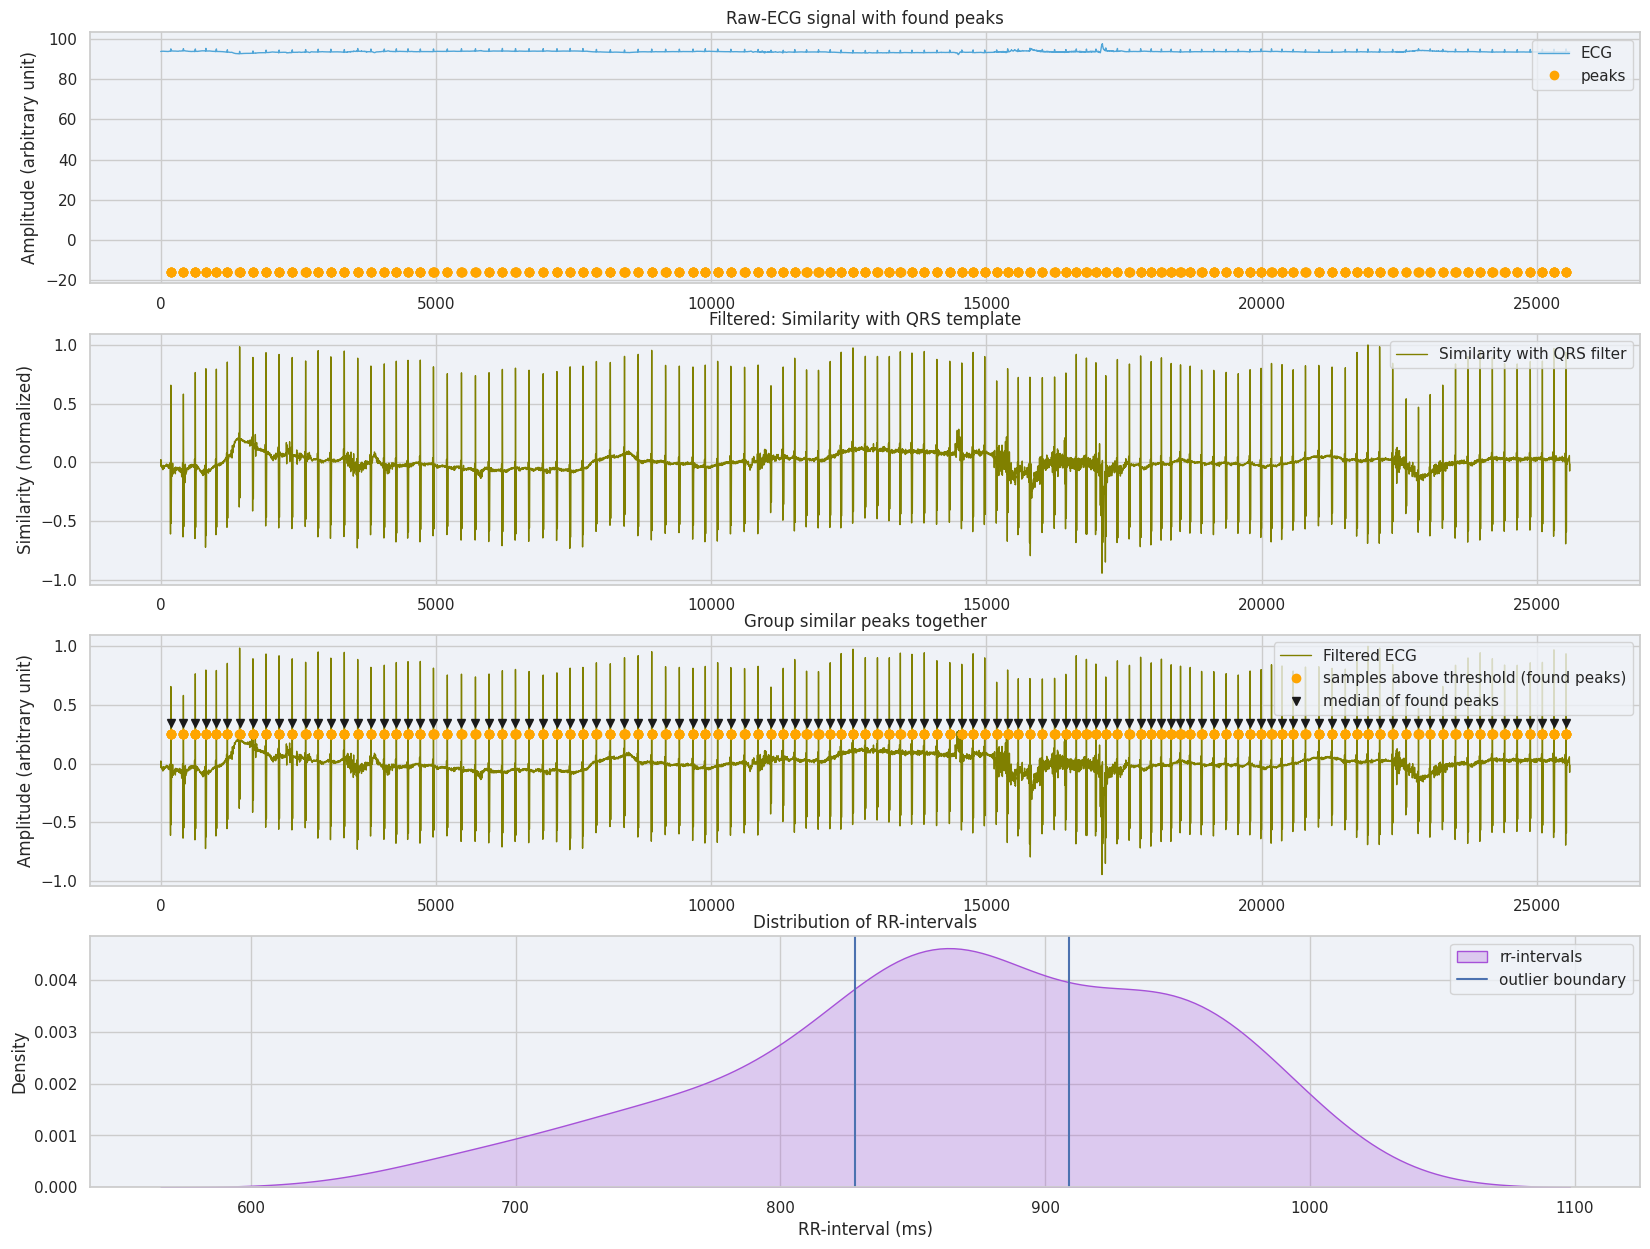

{'Mean RR (ms)': 868.4895833333334, 'STD RR/SDNN (ms)': 80.64013819728798, 'RMSSD (ms)': 47.1281793084727, 'NNxx': 3, 'pNNxx (%)': 2.6315789473684212}


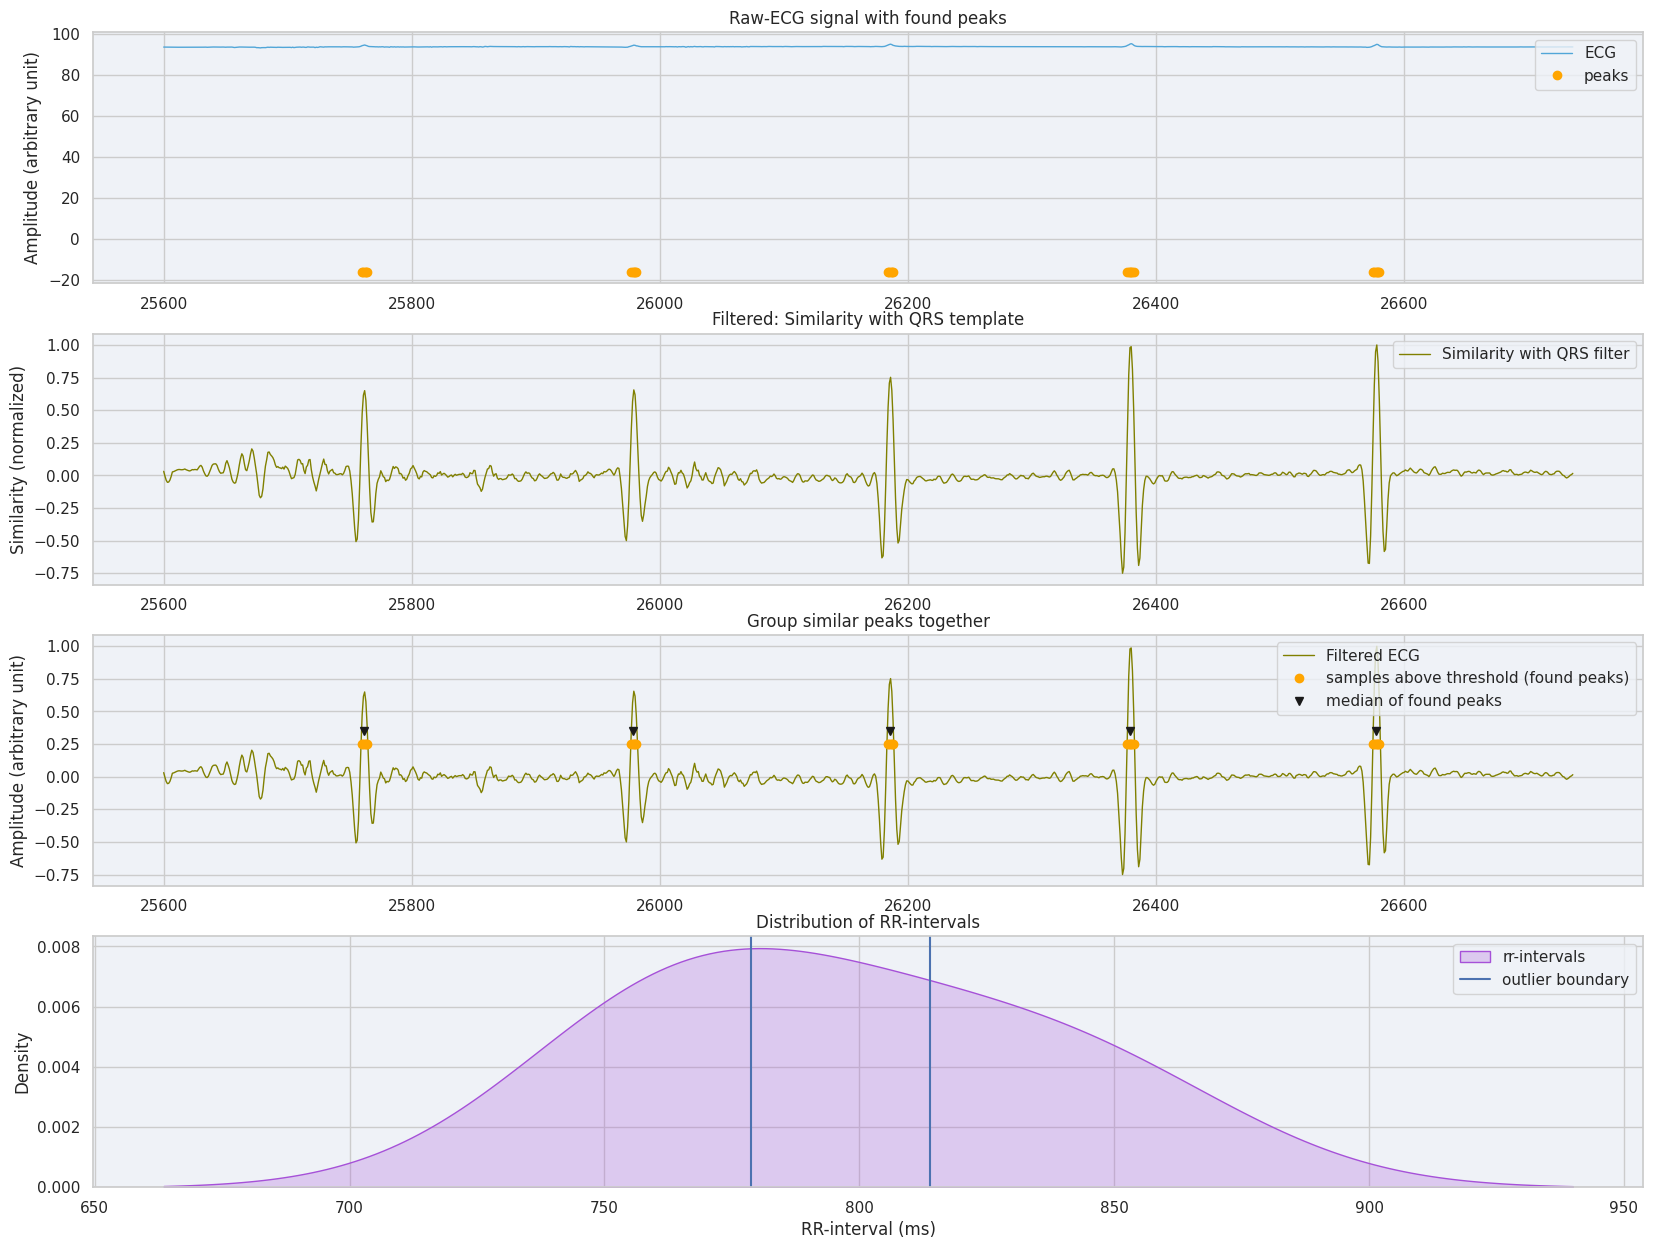

{'Mean RR (ms)': 796.38671875, 'STD RR/SDNN (ms)': 35.16642105474774, 'RMSSD (ms)': 39.224922738000174, 'NNxx': 0, 'pNNxx (%)': 0.0}


ValueError: first array argument cannot be empty

In [90]:

start = 0
stop =sampling_frequency*60*offset_min
duration = (stop-start) / sampling_frequency
print(duration)
outlier_thr = 0.5



sampfrom = start
sampto = stop
nr_plots = 3
for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
    
    cond_slice = (ecg_df_ii.index >= start) & (ecg_df_ii.index < stop)
    
    ecg_slice = ecg_df_ii.heartrate[cond_slice]
    
    peaks, similarity = detect_peaks(ecg_slice, threshold=0.3)
    
    grouped_peaks = group_peaks(peaks)
    
     # plot similarity
    plt.figure(figsize=(20, 15))
    
    plt.subplot(411)
    plt.title("Raw-ECG signal with found peaks")
    plt.plot(ecg_slice.index, ecg_slice, label="ECG", color="#51A6D8", linewidth=1)

    plt.plot(peaks, np.repeat(-16, peaks.shape[0]), label="peaks", color="orange", marker="o", linestyle="None")
    plt.legend(loc="upper right")
    #plt.xlabel("Samples")
    plt.ylabel("Amplitude (arbitrary unit)")
    
    
    plt.subplot(412)
    plt.title('Filtered: Similarity with QRS template')
    plt.plot(ecg_slice.index, similarity, label="Similarity with QRS filter", color="olive", linewidth=1)
    plt.legend(loc="upper right")
    #plt.xlabel("Samples")
    plt.ylabel("Similarity (normalized)")

    
    
    plt.subplot(413)
    plt.title("Group similar peaks together")
    plt.plot(ecg_slice.index, similarity, label="Filtered ECG", color="olive", linewidth=1)
    plt.plot(peaks, np.repeat(0.25, peaks.shape[0]),label="samples above threshold (found peaks)", color="orange", marker="o", linestyle="None")
    plt.plot(grouped_peaks, np.repeat(0.35, grouped_peaks.shape[0]), label="median of found peaks", color="k", marker="v", linestyle="None")
    plt.legend(loc="upper right")
    #plt.xlabel("Samples")
    plt.ylabel("Amplitude (arbitrary unit)")
    #plt.gca().set_xlim(0, 200)
    
    
    plt.subplot(414)
    
    grouped_peak_msec =group_peaks_from_ind_to_msec(grouped_peaks, 256)
    
    rr = np.diff(grouped_peak_msec)
    plt.title("Distribution of RR-intervals")
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore") # ignore FutureWarning 
        sns.kdeplot(rr, label="rr-intervals", color="#A651D8", shade=True)
        
    outlier_low = np.mean(rr) - outlier_thr * np.std(rr)
    outlier_high = np.mean(rr) + outlier_thr * np.std(rr)
    plt.axvline(x=outlier_low)
    plt.axvline(x=outlier_high, label="outlier boundary")
    plt.xlabel("RR-interval (ms)")
    plt.ylabel("Density")
    #plt.text(outlier_low - 370, 0.004, "outliers low (< mean - 2 sigma)")
    plt.legend()
    plt.show()
    
    print(timedomain(rr))
    
        
        
    
    

In [61]:
np.std(rr)

1250.2171387730884

In [69]:
np.mean(rr)

1201.8019153225807

In [70]:
threshold_low = 0.5
throshold_high = 0.1

In [71]:

cleaned_rr = filter_rr(rr, throshold_high, threshold_low)

1400
600


In [72]:
np.std(cleaned_rr)

61.1613732188504

In [73]:
np.mean(cleaned_rr)

1201.8019153225807

In [74]:
len(cleaned_rr)

248

In [79]:
comm_rr = []

In [80]:
comm_rr.extend(rr)

In [81]:
comm_rr.extend(cleaned_rr)

In [82]:
comm_rr

[1226.5625,
 1230.46875,
 1199.21875,
 1222.65625,
 1226.5625,
 1253.90625,
 1210.9375,
 1234.375,
 1261.71875,
 1269.53125,
 1269.53125,
 1226.5625,
 1191.40625,
 1171.875,
 1187.5,
 1214.84375,
 1175.78125,
 1121.09375,
 1093.75,
 1177.734375,
 1185.546875,
 1218.75,
 1210.9375,
 1201.171875,
 1197.265625,
 1167.96875,
 1160.15625,
 1201.171875,
 1212.890625,
 1191.40625,
 1167.96875,
 1203.125,
 1218.75,
 1224.609375,
 1230.46875,
 1269.53125,
 1291.015625,
 1300.78125,
 1289.0625,
 1273.4375,
 1265.625,
 1250.0,
 1242.1875,
 1187.5,
 1138.671875,
 1076.171875,
 1125.0,
 1167.96875,
 1167.96875,
 1195.3125,
 1187.5,
 1152.34375,
 1140.625,
 1105.46875,
 1111.328125,
 1134.765625,
 1152.34375,
 1148.4375,
 1187.5,
 1207.03125,
 1175.78125,
 1183.59375,
 1203.125,
 1195.3125,
 1201.171875,
 1205.078125,
 1175.78125,
 1164.0625,
 1175.78125,
 1164.0625,
 1097.65625,
 1105.46875,
 1140.625,
 1166.015625,
 1193.359375,
 1222.65625,
 1191.40625,
 1207.03125,
 1228.515625,
 1216.796875,
 1